<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Иванов Андрей Александрович

**Забавный факт о себе:** я ассист у того, кто составил это дз))

## Общая информация

__Дата выдачи:__ 26.11.2024

__Мягкий дедлайн:__ 23:59MSK 10.12.2024

__Жесткий дедлайн:__ 23:59MSK 13.12.2024

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов + 2 бонусных балла.

**Дисклеймер:** Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). Также помните, что простое копирование чужого кода не является самостоятельной работой.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [4]:
import gdown

url = "https://drive.google.com/drive/folders/1FkzxidGk6ZtMNtU0kwQGOr8cPrmbrGoN?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [5]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [6]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [7]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Обучить нейросеть предсказывать категорию новости
2. Построить предсказания для тех новостей, где мы ничего не знаем о категории
3. Использовать уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Провести аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (5 баллов + 1.8 бонусных)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [8]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [9]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [10]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [11]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [12]:
df_ria.target_tags.values[:3]

array([list([1286, 646, 210]), list([1073, 235, 210]), list([1444])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к нижнему регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [13]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [15]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [16]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [17]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [18]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [19]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.5 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [20]:
df_vk['title_clean'] = df_vk['title'].fillna("#UNKN").apply(normalise_text)

df_ria['snippet_clean'] = df_ria['snippet'].fillna("#UNKN").apply(normalise_text)
df_vk['snippet_clean'] = df_vk['snippet'].fillna("#UNKN").apply(normalise_text)

In [21]:
df_vk[['title', 'title_clean']].head()

,title,title_clean
0,"В ДНР заявили о задержании диверсантов, причас...",в днр заявили о задержании диверсантов причаст...
1,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",житель урала заминировал тц изза снятия сотов...
2,"В Черном море нашли ""потерянный флот Гитлера""",в черном море нашли потерянный флот гитлера
3,В США освободили задержанную российскую актрис...,в сша освободили задержанную российскую актрис...
4,Толкнувший Скабееву депутат Рады заявил о гроз...,толкнувший скабееву депутат рады заявил о гроз...


In [22]:
df_ria[['snippet', 'snippet_clean']].head()

,snippet,snippet_clean
0,Премьер-министр Израиля Биньямин Нетаньяху не ...,премьерминистр израиля биньямин нетаньяху не н...
1,"Результат реформ не может быть мгновенным, зая...",результат реформ не может быть мгновенным заяв...
4,Аргентинский теннисист Хуан Мартин дель Потро ...,аргентинский теннисист хуан мартин дель потро ...
5,Суд в американском штате Массачусетс отверг хо...,суд в американском штате массачусетс отверг хо...
6,"""Зимняя классика"" - матч регулярного чемпионат...",зимняя классика матч регулярного чемпионата н...


In [23]:
df_vk[['snippet', 'snippet_clean']].head(20)

,snippet,snippet_clean
0,NaN,unkn
1,NaN,unkn
2,NaN,unkn
3,NaN,unkn
4,NaN,unkn
5,NaN,unkn
6,NaN,unkn
7,NaN,unkn
8,NaN,unkn
9,NaN,unkn


## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [24]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [25]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [26]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.5 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [27]:
df['date'] = pd.to_datetime(df['date'])

df_test = df[df['date'].dt.month == 12]
df_val = df[df['date'].dt.month.isin([10, 11])]
df_train = df[~df['date'].dt.month.isin([10, 11, 12])]

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [28]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181231/1548960744.html,митрополит рязанский раскритиковал иронию судьбы,[263]
1,/20181231/1548958617.html,на украине позавидовали стене на границе с крымом,"[1383, 210]"
2,/20181231/1548957394.html,в госдуме предложили отказаться от газа в жилы...,"[584, 584, 35, 905, 1183]"
3,/20181231/1548954909.html,названы лучшие средства от похмелья,[263]
4,/20181231/1548957120.html,новогоднее поздравление порошенко разозлило по...,"[1383, 210]"


Напишем датасет для поставки данных в нейросеть.


In [29]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return (self.X_title[idx, :], self.y[idx])


__[0.5 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [30]:
class NewsDataset(Dataset):
    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):
        self.vocab = {word: idx for word, idx in vocab.items() if idx < vocab_size}
        self.max_classes = max_classes

        self.y = self.target_ohe(target)
        self.X_title = self.create_text(title, max_title_len)

        if snippet is not None:
            self.X_snippet = self.create_text(snippet, max_snippet_len)
        else:
            self.X_snippet = None

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i] * len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = []
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # Приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.X_snippet is None:
            return self.X_title[idx, :], self.y[idx]
        else:
            return self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx]


Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [31]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [32]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [33]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [34]:
!pip3 install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 44.0 MB/s eta 0:00:00


In [35]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [36]:
from pytorch_lightning.loggers import WandbLogger
import wandb
wandb.login()
wandb_logger = WandbLogger(project="news-classification", name="titles-only-model")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [37]:
print(device)

cuda:0


In [38]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: anday2004 (anday2004-higher-school-of-economics). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleClassifier | 3.5 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


https://wandb.ai/anday2004-higher-school-of-economics/news-classification/runs/umh92xe9 - без сниппетов

Правда я не могу доступ дать почему-то

__[1 балл] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [39]:
wandb.finish()
wandb_logger_2 = WandbLogger(project="news-classification", name="titles-snippets-model")

epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▆▆▅▆▅▄▅▅▄▄▄▃▅▄▄▄▅▃▅▄▃▃▁▂▂▁▁▂▂▂▂▁▁▂▂▁▃▁▂
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
val_loss,█▄▂▁▁
epoch,4
train_loss,8.20027
trainer/global_step,10694
val_loss,10.71854


In [40]:
class MultiInputClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
        embedded_title = self.embedding(title).mean(dim=1)
        embedded_snippet = self.embedding(snippet).mean(dim=1)
        combined = torch.cat((embedded_title, embedded_snippet), dim=1)
        return self.fc(combined)


In [41]:
train_dataset = NewsDataset(
    df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE,
    MAX_TITLE_LEN, CLASSES_NUM, snippet=df_train.snippet_clean.values, max_snippet_len=MAX_TITLE_LEN
)
val_dataset = NewsDataset(
    df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE,
    MAX_TITLE_LEN, CLASSES_NUM, snippet=df_val.snippet_clean.values, max_snippet_len=MAX_TITLE_LEN
)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)


In [42]:
class MultiInputLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log("val_loss", loss, prog_bar=True)
        return loss


In [43]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_multi_input = MultiInputClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module_multi_input = MultiInputLightningModule(model_multi_input, LR, criterion)

trainer = pl.Trainer(
    accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger_2)

trainer.fit(train_module_multi_input, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MultiInputClassifier | 4.0 M  | train
1 | criterion | CrossEntropyLoss     | 0      | train
-----------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.806    Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [44]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████████
train_loss,██▅▆▆▅▅▄▃▄▆▄▄▅▄▄▅▃▃▄▃▃▃▃▂▃▂▃▂▃▂▂▃▂▂▃▃▂▃▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_loss,█▄▂▁▁
epoch,4
train_loss,4.77281
trainer/global_step,10694
val_loss,10.48091


https://wandb.ai/anday2004-higher-school-of-economics/news-classification/runs/mm7y3gk4 - со сниппетами

<a href="https://ibb.co/c1Qknvq"><img src="https://i.ibb.co/s2qbYP7/Screenshot-2024-12-08-at-18-19-01.png" width=20000 border="0"></a>

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [45]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [46]:
test_dataset = NewsDataset(
    df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE,
    MAX_TITLE_LEN, CLASSES_NUM, snippet=df_test.snippet_clean.values, max_snippet_len=MAX_TITLE_LEN
)

test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, snippet, target in test_dataloader:
    logit = model_multi_input(title, snippet)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [47]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9954392313957214
Precision: 0.29558971524238586
Recall: 0.7712169885635376


In [48]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9982947111129761
Precision: 0.5235846042633057
Recall: 0.6139923930168152


In [49]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983217120170593
Precision: 0.012242144905030727
Recall: 0.01060455571860075


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [50]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, target in dataloader:
        logit = model(title)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.5 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ В контексте модели, предназначенной для классификации новостей, точность является ключевым фактором, так как некорректное присвоение категорий может привести к серьезным недопониманиям и дезинформации. Представим ситуацию, где новостные статьи о серьезных политических событиях или экономических кризисах ошибочно классифицируются как развлекательный контент. Это не только снизит доверие читателей к новостному источнику, но и может привести к недооценке важности и срочности реальных событий. Например, новость о финансовом крахе, помеченная как "развлечения", может не получить должного внимания со стороны аудитории, что потенциально ведет к упущенным возможностям для своевременного реагирования или принятия мер. В этом контексте, высокая точность гарантирует, что каждая новость получит соответствующую классификацию, что критически важно для информирования общественности и поддержания надежности новостного ресурса.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [51]:
def find_best_threshold(pred_prob, target, metric_fn, thresholds=np.arange(0.01, 1.01, 0.01)):
    best_metric = 0
    best_threshold = 0.0

    for threshold in thresholds:
        y_pred = (pred_prob > threshold).int()
        metric_value = metric_fn(target, y_pred)

        if metric_value > best_metric:
            best_metric = metric_value
            best_threshold = threshold

    return best_threshold


In [52]:
def get_predict(model, dataset, use_snippet=False):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=len(dataset))

    for batch in dataloader:
        if use_snippet:
            title, snippet, target = batch
            logit = model(title, snippet)
        else:
            if len(batch) == 3:
                title, _, target = batch
            else:
                title, target = batch

            logit = model(title)

        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == len(dataset)
    return pred_prob, target


In [53]:
pred_prob, target = get_predict(model_baseline, val_dataset, use_snippet=False)
best_threshold = find_best_threshold(pred_prob, target, precision)
print(f"Оптимальный порог для Precision: {best_threshold}")

Оптимальный порог для Precision: 0.13


In [54]:
pred_prob_no_snippet, target_no_snippet = get_predict(model_baseline, test_dataset, use_snippet=False)
y_pred_no_snippet = (pred_prob_no_snippet > best_threshold).int()
precision_no_snippet = precision(target_no_snippet, y_pred_no_snippet)

pred_prob_snippet, target_snippet = get_predict(model_multi_input, test_dataset, use_snippet=True)
y_pred_snippet = (pred_prob_snippet > best_threshold).int()
precision_snippet = precision(target_snippet, y_pred_snippet)

print(f"Precision без сниппетов: {precision_no_snippet}")
print(f"Precision со сниппетами: {precision_snippet}")

Precision без сниппетов: 0.5869354605674744
Precision со сниппетами: 0.5907913446426392


__[0.5 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [55]:
df_oob.head()

,href,title_clean,target_tags
0,/20181231/1548960744.html,митрополит рязанский раскритиковал иронию судьбы,[263]
1,/20181231/1548958617.html,на украине позавидовали стене на границе с крымом,"[1383, 210]"
2,/20181231/1548957394.html,в госдуме предложили отказаться от газа в жилы...,"[584, 584, 35, 905, 1183]"
3,/20181231/1548954909.html,названы лучшие средства от похмелья,[263]
4,/20181231/1548957120.html,новогоднее поздравление порошенко разозлило по...,"[1383, 210]"


In [56]:
oob_dataset = NewsDataset(
    df_oob.target_tags.values,
    df_oob.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM)

oob_dataloader = DataLoader(oob_dataset, shuffle=False, batch_size=4096, num_workers=4)
pred_prob_oob, target_oob = get_predict(model_baseline, oob_dataset, use_snippet=False)
y_pred_oob = (pred_prob_oob > best_threshold).int()

exact_match_oob = exact_match(target_oob, y_pred_oob)
precision_oob = precision(target_oob, y_pred_oob)
recall_oob = recall(target_oob, y_pred_oob)

print(f"Exact Match: {exact_match_oob:.4f}")
print(f"Precision: {precision_oob:.4f}")
print(f"Recall: {recall_oob:.4f}")

Exact Match: 0.9986
Precision: 0.5399
Recall: 0.4040


Качество просело, но незначительно.

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.9 балла] Бонусное задание 1:__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

1. https://wandb.ai/anday2004-higher-school-of-economics/news-classification/runs/ij1bobzd

ну чет не очень получилось(

In [57]:
class MultiInputClassifier_1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, kernel_size=3, num_filters=64):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.conv_title = nn.Conv1d(in_channels=embedding_dim,
                                    out_channels=num_filters,
                                    kernel_size=kernel_size,
                                    padding=kernel_size // 2)
        self.conv_snippet = nn.Conv1d(in_channels=embedding_dim,
                                      out_channels=num_filters,
                                      kernel_size=kernel_size,
                                      padding=kernel_size // 2)

        self.fc_title_only = nn.Linear(num_filters, output_dim)
        self.fc_both = nn.Linear(num_filters * 2, output_dim)


    def forward(self, title, snippet=None):
        embedded_title = self.embedding(title).permute(0, 2, 1)
        conv_title = F.relu(self.conv_title(embedded_title))
        pooled_title = F.max_pool1d(conv_title, kernel_size=conv_title.size(2)).squeeze(2)

        if snippet is not None:
            embedded_snippet = self.embedding(snippet).permute(0, 2, 1)
            conv_snippet = F.relu(self.conv_snippet(embedded_snippet))
            pooled_snippet = F.max_pool1d(conv_snippet, kernel_size=conv_snippet.size(2)).squeeze(2)

            combined = torch.cat((pooled_title, pooled_snippet), dim=1)
            output = self.fc_both(combined)
        else:
            output = self.fc_title_only(pooled_title)

        return output


In [58]:
wandb_logger_conv = WandbLogger(project="news-classification", name="bonus-1")

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_conv = MultiInputClassifier_1(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module_conv = MultiInputLightningModule(model_conv, LR, criterion)

trainer = pl.Trainer(
    accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger_conv)

trainer.fit(train_module_conv, train_dataloader, val_dataloader)

wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | MultiInputClassifier_1 | 3.4 M  | train
1 | criterion | CrossEntropyLoss       | 0      | train
-------------------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.690    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆█████
train_loss,▇█▇█▆▇▄▄▄▃▄▃▂▂▅▃▃▂▁▃▄▃▂▃▃▃▃▃▄▂▃▂▂▁▃▄▂▁▃▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
val_loss,█▁▁▃▆
epoch,4
train_loss,7.33862
trainer/global_step,10694
val_loss,12.00582


In [60]:
oob_dataset = NewsDataset(
    df_oob.target_tags.values,
    df_oob.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM)

oob_dataloader = DataLoader(oob_dataset, shuffle=False, batch_size=4096, num_workers=4)
pred_prob_oob, target_oob = get_predict(model_conv, oob_dataset, use_snippet=False)
y_pred_oob = (pred_prob_oob > 0.01).int()

exact_match_oob = exact_match(target_oob, y_pred_oob)
precision_oob = precision(target_oob, y_pred_oob)
recall_oob = recall(target_oob, y_pred_oob)

print(f"Exact Match: {exact_match_oob:.4f}")
print(f"Precision: {precision_oob:.4f}")
print(f"Recall: {recall_oob:.4f}")

Exact Match: 0.9961
Precision: 0.0007
Recall: 0.0015


__[0.9 балла] Бонусное задание 2:__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1.5 балла] Задание 7:__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

1. Я спросил у гпт, какие есть модели, которые работают с русским языком, умеют в многоклассовую классификацию, и при этом легкие и быстрые. Мне предложило "cointegrated/rubert-tiny", я ее и взял

Код писал сам, только гпт подсказал, что нужно сделать с trainer, чтобы все заработало.

https://wandb.ai/anday2004-higher-school-of-economics/news-classification/runs/pyq6twtw

Ссылка на wandb не работает... я щас какой-нибудь скрин кину, потому что мне не дает сделать public project. Там были precision и recall 0 вообще... поэтому я решил попробовать что-то другое

<a href="https://ibb.co/Tms3J3Q"><img src="https://i.ibb.co/SRzCHCk/Screenshot-2024-12-08-at-19-23-52.png" width=10000 border="0"></a>

2. Я нашел вот такое вот

https://github.com/dtolk/multilabel-BERT/blob/master/notebooks/multi_label_text_classification_BERT.ipynb

Потом я переиначивал под свою задачу и изменил модель на ту, которая умеет работать с русским текстом. И я делал без сниппетов.

https://wandb.ai/anday2004-higher-school-of-economics/news-classification/runs/i597noxo (с доступом все еще проблемы)

Получилось precision 0.48

<a href="https://ibb.co/fddHCYN"><img src="https://i.ibb.co/600F4Rt/Screenshot-2024-12-09-at-01-47-21.png" width=10000 border="0"></a>

In [61]:
NUM_CLASSES = len(idx2tag)
MAX_LEN = 20
BATCH_SIZE = 16
EPOCHS = 3
LR = 1e-3

In [62]:
from transformers import BertTokenizer, BertModel, AdamW
import tqdm as tq
from collections import defaultdict

In [63]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [64]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets)

class BERTClass(nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased', return_dict=True)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(768, NUM_CLASSES)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

class NewsDataset_new(Dataset):
    def __init__(self, targets, titles, tokenizer, max_title_len):
        self.targets = targets
        self.titles = titles
        self.tokenizer = tokenizer
        self.max_title_len = max_title_len

    def target_ohe(self, target, num_classes):
        y = torch.zeros(num_classes, dtype=torch.float)
        for t in target:
            if t < num_classes:
                y[t] = 1.0
        return y

    def __getitem__(self, idx):
        title = self.titles[idx]
        inputs = self.tokenizer(
            title,
            max_length=self.max_title_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        targets = self.targets[idx]
        targets = self.target_ohe(targets, num_classes=NUM_CLASSES)

        return {**inputs, 'targets': targets, 'title': title}

    def __len__(self):
        return len(self.titles)

train_dataset = NewsDataset_new(
    targets=df_train.target_tags.values,
    titles=df_train.title_clean.values,
    tokenizer=tokenizer,
    max_title_len=MAX_LEN
)

val_dataset = NewsDataset_new(
    targets=df_val.target_tags.values,
    titles=df_val.title_clean.values,
    tokenizer=tokenizer,
    max_title_len=MAX_LEN
)

test_dataset = NewsDataset_new(
    targets=df_test.target_tags.values,
    titles=df_test.title_clean.values,
    tokenizer=tokenizer,
    max_title_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

model = BERTClass().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

def train_model(training_loader, model, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_samples = 0

    for batch_idx, data in tq.tqdm(enumerate(training_loader), total=len(training_loader)):
        inputs = {key: val.to(device) for key, val in data.items() if key not in ['targets', 'title']}
        targets = data['targets'].to(device)

        outputs = model(**inputs)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        predictions = torch.sigmoid(outputs) > 0.5
        correct_predictions += (predictions == targets).sum().item()
        total_samples += targets.numel()
        losses.append(loss.item())

    return float(correct_predictions) / total_samples, np.mean(losses)


def eval_model(validation_loader, model, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for data in validation_loader:
            inputs = {key: val.to(device) for key, val in data.items() if key not in ['targets', 'title']}
            targets = data['targets'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            predictions = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predictions == targets).sum().item()
            total_samples += targets.numel()

    return float(correct_predictions) / total_samples, np.mean(losses)


wandb.init(project="news-classification", name="bert-base")

history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS + 1):
    print(f'\nEpoch {epoch}/{EPOCHS}')

    train_acc, train_loss = train_model(train_loader, model, optimizer, device)
    val_acc, val_loss = eval_model(val_loader, model, device)
    scheduler.step(val_acc)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    })

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

wandb.finish()

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


Epoch 1/3


100%|██████████| 8555/8555 [18:18<00:00,  7.79it/s]


train_loss=0.0282, val_loss=0.0102, train_acc=0.9942, val_acc=0.9981

Epoch 2/3


100%|██████████| 8555/8555 [18:15<00:00,  7.81it/s]


train_loss=0.0100, val_loss=0.0098, train_acc=0.9980, val_acc=0.9981

Epoch 3/3


100%|██████████| 8555/8555 [18:23<00:00,  7.75it/s]


train_loss=0.0084, val_loss=0.0080, train_acc=0.9983, val_acc=0.9985


epoch,▁▅█
train_acc,▁██
train_loss,█▂▁
val_acc,▁▂█
val_loss,█▇▁
epoch,3
train_acc,0.99833
train_loss,0.00838
val_acc,0.99849
val_loss,0.00801


In [65]:
test_acc, test_loss = eval_model(test_loader, model, device)
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

Test Accuracy: 0.9985, Test Loss: 0.0080


In [66]:
def get_predictions(model, data_loader):
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data["targets"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        outputs = torch.sigmoid(outputs).detach().cpu()
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values


oob_dataset = NewsDataset_new(
    targets=df_oob.target_tags.values,
    titles=df_oob.title_clean.values,
    tokenizer=tokenizer,
    max_title_len=20
)

oob_loader = DataLoader(
    oob_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

titles, predictions, prediction_probs, target_values = get_predictions(model, oob_loader)

y_pred = (torch.tensor(predictions) > 0).int()
y_true = torch.tensor(target_values)

exact_match_score = exact_match(y_true, y_pred)
precision_score = precision(y_true, y_pred)
recall_score = recall(y_true, y_pred)

print(f"Exact Match: {exact_match_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")

Exact Match: 0.9986
Precision: 0.4884
Recall: 0.2714


Сравните все обученные модели между собой на тестовой выборке.

In [67]:
test_dataset = NewsDataset(
    df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE,
    MAX_TITLE_LEN, CLASSES_NUM, snippet=df_test.snippet_clean.values, max_snippet_len=MAX_TITLE_LEN
)

test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, snippet, target in test_dataloader:
    logit = model_multi_input(title, snippet)
    pred_prob = F.softmax(logit, dim=1)

pred_prob_no_snippet, target_no_snippet = get_predict(model_baseline, test_dataset, use_snippet=False)
y_pred_no_snippet = (pred_prob_no_snippet > best_threshold).int()
precision_no_snippet = precision(target_no_snippet, y_pred_no_snippet)

pred_prob_snippet, target_snippet = get_predict(model_multi_input, test_dataset, use_snippet=True)
y_pred_snippet = (pred_prob_snippet > best_threshold).int()
precision_snippet = precision(target_snippet, y_pred_snippet)

print(f"Precision без сниппетов: {precision_no_snippet}")
print(f"Precision со сниппетами: {precision_snippet}")

Precision без сниппетов: 0.5869354605674744
Precision со сниппетами: 0.5907913446426392


In [68]:
test_dataset = NewsDataset_new(
    targets=df_test.target_tags.values,
    titles=df_test.title_clean.values,
    tokenizer=tokenizer,
    max_title_len=MAX_LEN
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

titles, predictions, prediction_probs, target_values = get_predictions(model, oob_loader)

y_pred = (torch.tensor(predictions) > 0).int()
y_true = torch.tensor(target_values)

exact_match_score = exact_match(y_true, y_pred)
precision_score = precision(y_true, y_pred)
recall_score = recall(y_true, y_pred)

print(f"Precision на pretrained: {precision_score:.4f}")

Precision на pretrained: 0.4884


## Часть 2: предсказание категорий (0.5 балла)

**[0.5 балла] Задание 8:** Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [69]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]
vk_dataset = NewsDataset(
    df_vk.target_tags.values,
    df_vk.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
    df_vk.snippet_clean.values,
    MAX_TITLE_LEN
)

vk_dataloader = DataLoader(vk_dataset, shuffle=False, batch_size=32)

In [70]:
all_predictions = []

for batch in vk_dataloader:
    title, snippet, tag = batch
    log = model_multi_input(title, snippet)
    prob = F.softmax(log, dim=1)
    prediction = (1 * (prob > best_threshold)).int()
    all_predictions.append(prediction)

all_predictions_tensor = torch.cat(all_predictions, dim=0)

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [71]:
pd.DataFrame(all_predictions_tensor).to_csv('predictions.csv')

## Часть 3: сентимент-классификатор (1.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [72]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


In [73]:
df_comments.shape

(2612629, 5)

**[1.5 балла] Задание 9:** Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

Ответ:

1. Автор модели  S. Smetanin.
2. Архитектура модели основана на RuBERT-tiny2, это более компактная версия оригинальной модели RuBERT. С учетом того, что модель имеет 29.2 миллиона параметров, она считается сравнительно небольшой по современным меркам.
3. Модель обучена на комбинации наборов данных, включающих новостные тексты и комментарии из различных источников. Это делает её потенциально пригодной для классификации комментариев в ВК, особенно если эти комментарии имеют аналогичный контекст или стиль. Однако точность ее применения будет зависеть от специфики комментариев и контекста в ВК.

Установим библиотеку. 🤗🤗🤗

In [74]:
!pip3 install transformers

**Варнинг:** в этом задании не обязательно ждать, пока код проскорит весь датасет - это долго. Напишите код, проверьте, что он корректно работает - проскорьте пару десятков строк датасета и принтаните их. Дальше вы можете взять уже проскоренный датасет. Возможно, кто-то проскорит все раньше остальных и захочет поделиться результатом. Вот его разрешается взять, как готовый результат выполнения задания. Главное - покажите, что ваш код тоже работает.

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [75]:
from transformers import pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [76]:
model = pipeline("sentiment-analysis", model="seara/rubert-tiny2-russian-sentiment", device=device)

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [77]:
df_exapmple = df_comments.head(50)

df_exapmple['sentiment_verdict'] = df_exapmple['text'].apply(lambda x: model(x)[0]['label'])
df_exapmple['sentiment_score'] = df_exapmple['text'].apply(lambda x: model(x)[0]['score'])

df_exapmple.head(10)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223
5,24006379.0,24006362.0,2019-02-01 23:18:00,"[id109937745|Илья], Донецкая Народная Республи...",3.0,neutral,0.842851
6,24006380.0,24006362.0,2019-02-01 23:18:44,"[id89551382|Юрий], это где?",2.0,neutral,0.924576
7,24006381.0,24006362.0,2019-02-01 23:18:55,"[id109937745|Илья], Донецкая Народная Республика.",1.0,neutral,0.911959
8,24006383.0,24006362.0,2019-02-01 23:20:00,"[id483059794|Марк], Донецк российский отделилс...",0.0,neutral,0.787388
9,24006384.0,24006362.0,2019-02-01 23:20:22,"[id109937745|Илья], на планете Земля.",0.0,neutral,0.883703


In [78]:
#df_comments['sentiment_verdict'] = df_comments['title_clean'].apply(lambda x: model(x)[0]['label'])
#df_comments['sentiment_score'] = df_comments['title_clean'].apply(lambda x: model(x)[0]['score'])

На первых 50 все работает! применять ко всем не буду, там все ок будет)

В чат кидали файл с проскоренным всем, я этому доброму человеку верю, поэтому буду работать с этим.

In [79]:
df_sent = pd.read_csv('https://github.com/aeksin/datasets/releases/download/new12/df_comments.csv', sep=',')

In [80]:
df_sent.head()

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223


## Часть 4: аналитика (3 балла + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.6 балла] Задание 10:__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [81]:
print( f'Позитивные: {((df_sent.sentiment_verdict == "positive")).mean()}, Негативные: {(df_sent.sentiment_verdict == "negative").mean()}')
df_sent[df_sent.sentiment_verdict == 'positive'].sort_values('sentiment_score', ascending = 0)[:10].text

Позитивные: 0.07200180354730809, Негативные: 0.22879865453533585


,text
493792,"Отлично, молодец!Поздравляю!✨💫🌟💥"
1379447,Отлично! Просто отлично! Молодцы! Поздравляю о...
2352264,"отлично,молодцы!!!👍 респект"
2057938,Отлично! \nПоздравляем!!!
2074701,"Отлично,я рад."
236794,"Отлично,молодцы"
1300899,"Отлично,люблю ездить в Эмираты"
288287,Отлично! Здоровья всем желаю!
411428,Я очень счастлива! Поздравляю!
1681663,"Отлично, просто отлично!"


__[0.6 балла] Задание 11:__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [82]:
pd.DataFrame(df_sent.groupby('post_id')['sentiment_verdict'].value_counts())

count
post_id    sentiment_verdict       
17976037.0 neutral              169
           negative              57
           positive              12
17976198.0 neutral               40
           negative              10
...                             ...
24006240.0 negative              11
           positive               3
24006362.0 neutral               35
           negative              10
           positive               2

[59025 rows x 1 columns]

In [83]:
df_sent['pos_num'] = df_sent.groupby('post_id')['sentiment_verdict'].transform(lambda x: (x == 'positive').sum())
df_sent['neg_num'] = df_sent.groupby('post_id')['sentiment_verdict'].transform(lambda x: (x == 'negative').sum())


__[0.6 балла] Задание 12:__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

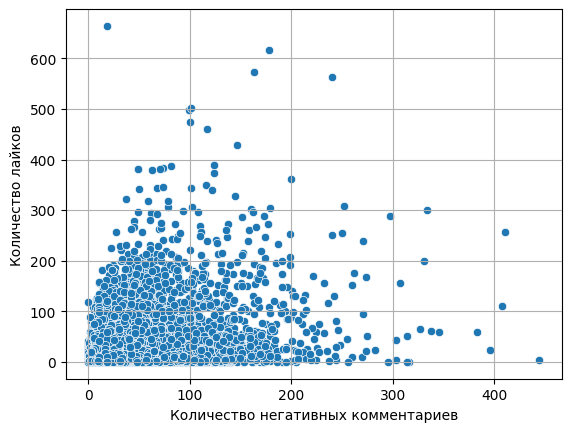

In [84]:
df_vis = df_sent.drop_duplicates(subset=['post_id'])
df_vis.head()

sns.scatterplot(x=df_vis['neg_num'],y=df_vis['likes'])
plt.xlabel('Количество негативных комментариев')
plt.ylabel('Количество лайков')
plt.grid(True)

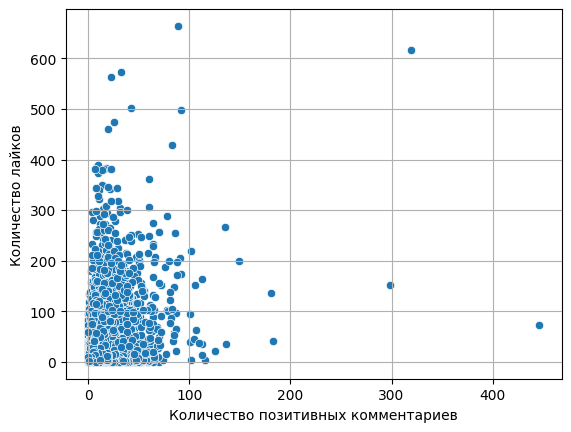

In [85]:
sns.scatterplot(x=df_vis['pos_num'],y=df_vis['likes'])
plt.xlabel('Количество позитивных комментариев')
plt.ylabel('Количество лайков')
plt.grid(True)

__[0.6 балла] Задание 13:__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаeт, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [86]:
sentiment_summary = df_sent.groupby('post_id')['sentiment_verdict'].value_counts().unstack().fillna(0)
sentiment_summary.columns = ['neg_comments', 'pos_comments', 'neut_comments']
formatted_aggregated_data = sentiment_summary.reset_index()
formatted_aggregated_data.head()

,post_id,neg_comments,pos_comments,neut_comments
0,17976037.0,57.0,169.0,12.0
1,17976198.0,10.0,40.0,1.0
2,17976601.0,11.0,56.0,0.0
3,17976766.0,11.0,29.0,8.0
4,17976905.0,31.0,77.0,4.0


In [87]:
aggregated_data2 = df_sent.groupby('post_id')['sentiment_verdict'].value_counts().unstack(fill_value=0)
aggregated_data2.columns = ['negative_comments', 'positive_comments','neutral_comments']
aggregated_data2 = aggregated_data2.reset_index(drop=False)
aggregated_data2['neg_neut']=aggregated_data2['negative_comments']+aggregated_data2['neutral_comments']
itog = aggregated_data2.drop(['negative_comments','neutral_comments'],axis=1)
itog.head()

,post_id,positive_comments,neg_neut
0,17976037.0,169,69
1,17976198.0,40,11
2,17976601.0,56,11
3,17976766.0,29,19
4,17976905.0,77,35


In [88]:
def confidence_lower_bound(row):
    positive = row['positive_comments']
    negative_neutral = row['neg_neut']
    numerator = 1 + positive
    denominator = 1 + negative_neutral
    avg = numerator / (numerator + denominator)
    variance = np.sqrt(numerator * denominator / ((numerator + denominator) ** 2 * (numerator + denominator + 1)))
    return avg - 1.65 * variance

itog['confidence_lower'] = itog.apply(confidence_lower_bound, axis=1)
ranked_news = itog.sort_values('confidence_lower', ascending=False)
top_ten_positive_news = ranked_news.head(10)
top_ten_positive_news

,post_id,positive_comments,neg_neut,confidence_lower
15175,22847411.0,43,1,0.907440
15483,22931980.0,54,2,0.900702
4209,19436158.0,49,2,0.891509
9942,21399230.0,21,0,0.887837
6423,20233566.0,131,10,0.886437
9714,21329261.0,19,0,0.877466
9712,21328552.0,82,6,0.875898
16389,23141871.0,72,5,0.875180
15353,22894953.0,18,0,0.871527
19230,23827375.0,18,0,0.871527


In [89]:
df_vk[df_vk.id.isin(top_ten_positive_news.post_id)].title.values

array(['В Нидерландах нашли картину, которая может принадлежать кисти Ван Гога',
       'Астрономы предупредили об угрозе мощного взрыва в Млечном Пути',
       'НАСА возобновит совместные с "Роскосмосом" пилотируемые старты',
       'В документах Word нашли опасную уязвимость',
       'Под Каиром нашли зал торжеств фараона Рамзеса II',
       'На Кавказе в Центре восстановления леопарда родились пять котят',
       'Пользователь Twitter предсказал исход матчей ЧМ с участием России',
       'NASA показало голубые дюны на Марсе',
       'Астрономы открыли "невозможную" галактику, где нет темной материи',
       'Палеонтологи нашли в Египте останки ранее неизвестного науке динозавра'],
      dtype=object)

Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.6 балла] Задание 14:__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__ В этом контексте, можно сказать, что фокус лежит на жанровой классификации новостей, что предполагает необходимость разделения их на категории. Интересно предположить, что новости, связанные с культурой и искусством, часто имеют положительную или нейтральную окраску. Это предположение основывается на общих наблюдениях о том, что такие темы обычно связаны с более позитивными аспектами жизни.

__[0.2 балла] Бонусное задание 3:__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [90]:
import statsmodels.api as sm
df_sent['thread_count'] = df_sent.groupby('post_id')['sentiment_verdict'].transform(lambda x: (x.isin(['positive', 'negative', 'neutral'])).sum())
negative_sentiment = df_sent[df_sent.sentiment_verdict == 'negative']
x_obs = sm.add_constant(negative_sentiment[['sentiment_score']])
model_ols = sm.OLS(negative_sentiment['thread_count'], x_obs).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           thread_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     481.7
Date:                Mon, 09 Dec 2024   Prob (F-statistic):          9.89e-107
Time:                        10:32:05   Log-Likelihood:            -3.9958e+06
No. Observations:              597766   AIC:                         7.992e+06
Df Residuals:                  597764   BIC:                         7.992e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             217.5463      1.325    1

Оцененная линейная регрессия показывает, что p-value при коэффициенте у вероятности негативного класса равно 0, значит он значим, значит, можно делать вывод о том, что между размером треда и вероятностью негативного комментария действительно есть статистически значимая связь